# Homework 1
# Name: Praveen Saravanan
# USC ID: 7939976839

Doing the neccecary imports for the tools!

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns            
from pathlib import Path
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from numpy.linalg import pinv

# Importing the data - a

In [2]:
DATA_DIR = Path("../data")

Adding column names externally cuz the .dat files dont have them, manually reading them from the arff files... and a label map so i can expand the abreviations...

In [3]:
col_names = ["pelvic_incidence", "pelvic_tilt", "lumbar_lordosis_angle", "sacral_slope", "pelvic_radius", "degree_spondylolisthesis", "label_raw"]

label_map = {"NO": "Normal", "AB": "Abnormal", "DH": "Hernia", "SL": "Spondylo"}

Creating 2 data frames. df2 with the classes Normal and Abnormal. df3 with the classes Normal, Hernia and Spondylolisthesis (will be calling it spondy cuz its easier to read)

In [4]:
df2 = pd.read_csv(DATA_DIR / "column_2C.dat", sep=r"\s+", names=col_names)

df2["label"] = df2["label_raw"].map(label_map)
df2 = df2.drop(columns="label_raw")

In [5]:
df3 = pd.read_csv(DATA_DIR / "column_3C.dat", sep=r"\s+", names=col_names)

df3["label"] = df3["label_raw"].map(label_map)
df3 = df3.drop(columns="label_raw")

Used a tiny bit of gpt to figure out how to label the data...
It told me to change a few things, adding col_names in code and expanding in data abreviations from NO AB DH SL to its corresponding name.

# Preprocressing and Exploratory Data analysis - b

### b - (i). Pairplots of data with 2C and 3C

Creating a pairplot function to make pairplots (much cleaner than scatterplotting each feature against eacher seperately)

In [6]:
def pairplot(df, title, palette):
    sns.pairplot(
        df,
        hue="label",
        palette=palette,
        corner=True,        # False to add the inverse as well, looks very cool and data sciency
        plot_kws=dict(alpha=0.7, s=40, edgecolor="k")
    )
    plt.suptitle(title, y=1.02, fontsize=16)
    plt.show()

Pair plotting the data set with just Normal and Abnormal

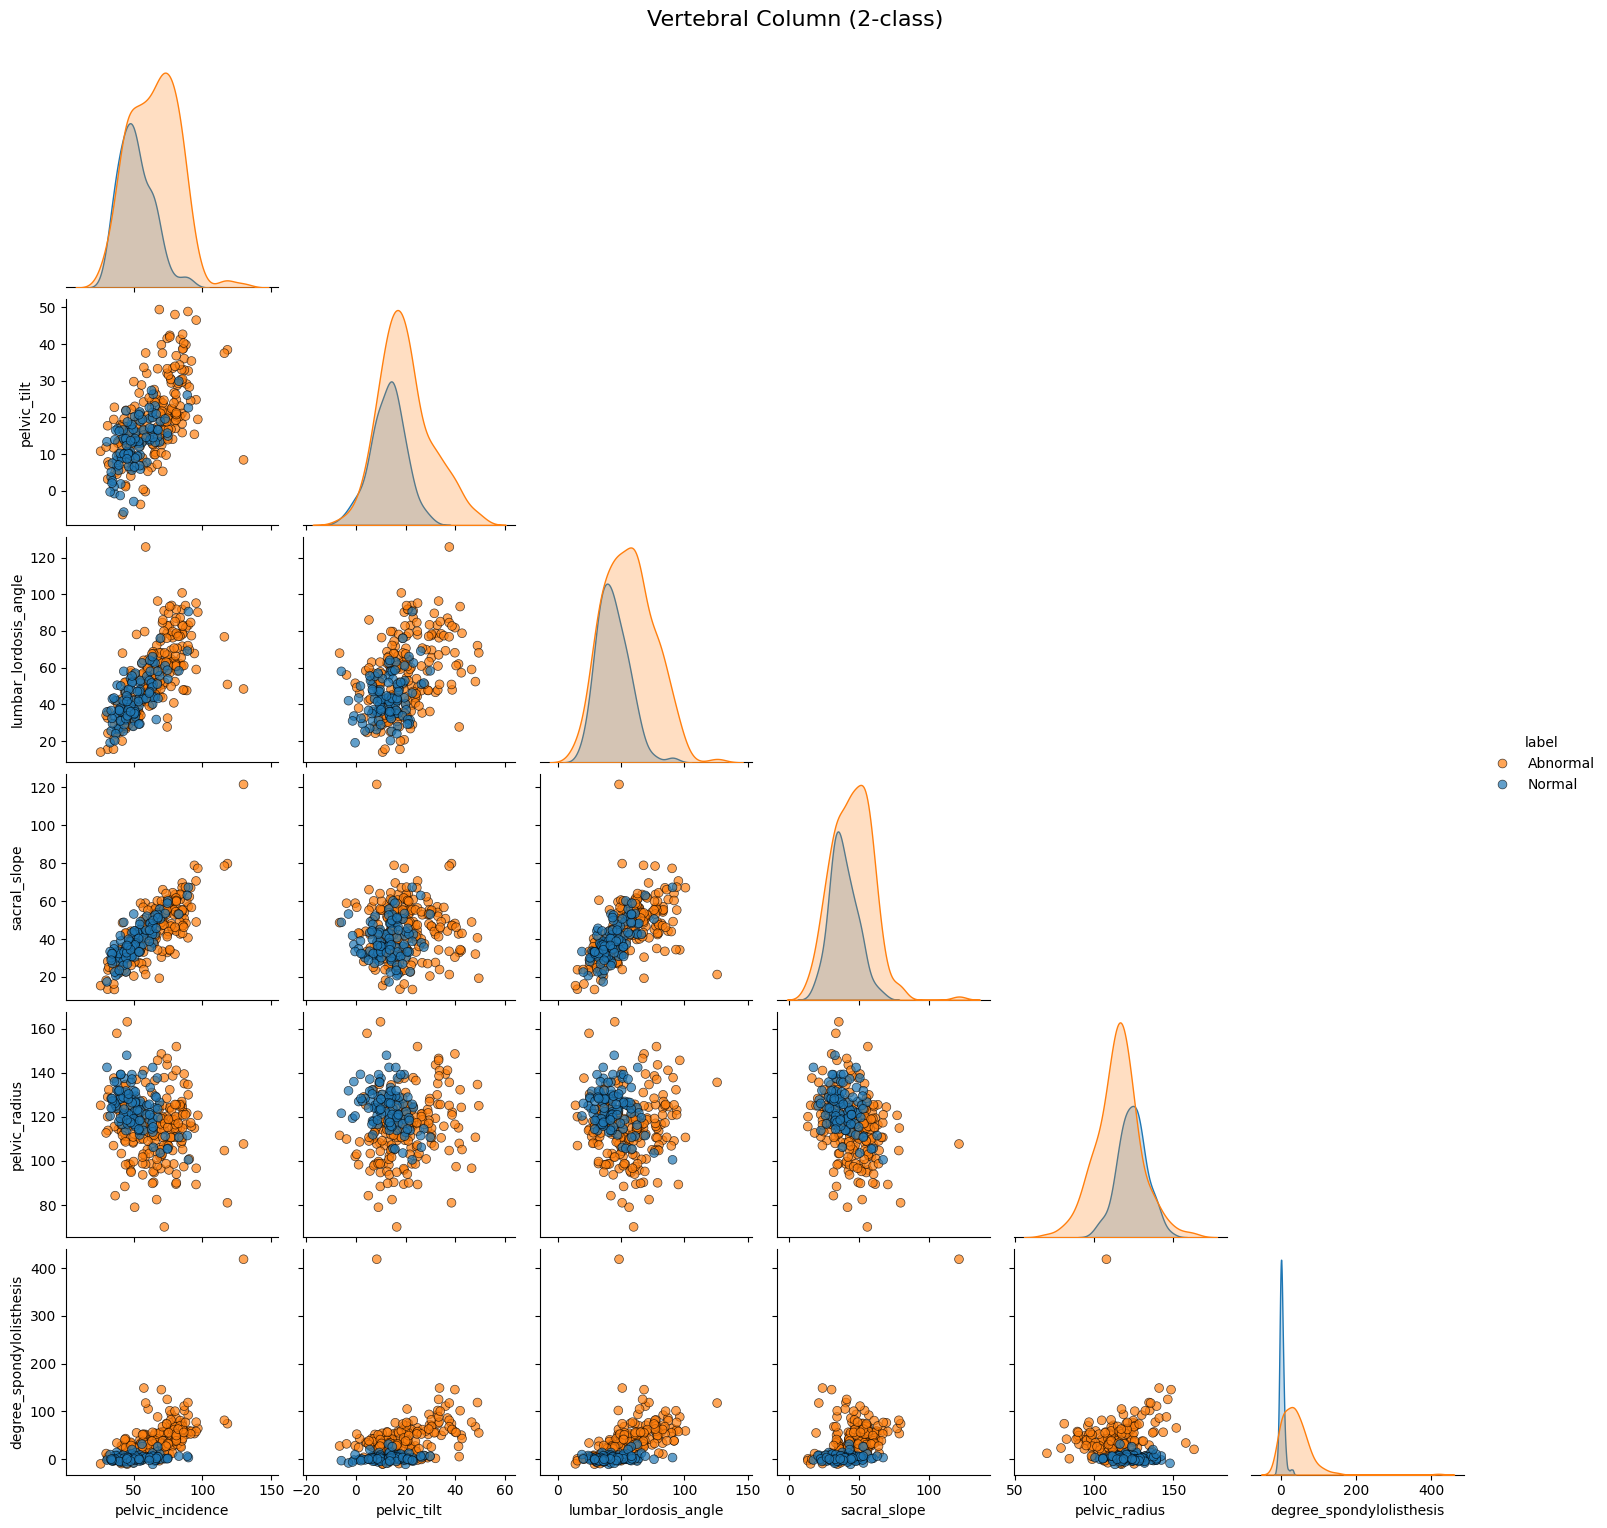

In [7]:
pairplot(df2, "Vertebral Column (2-class)", palette={"Normal": "#1f77b4", "Abnormal": "#ff7f0e"})

Pair plotting the data set with Normal, Hernia and Spondylolisthesis (Abnormal but subclassified)

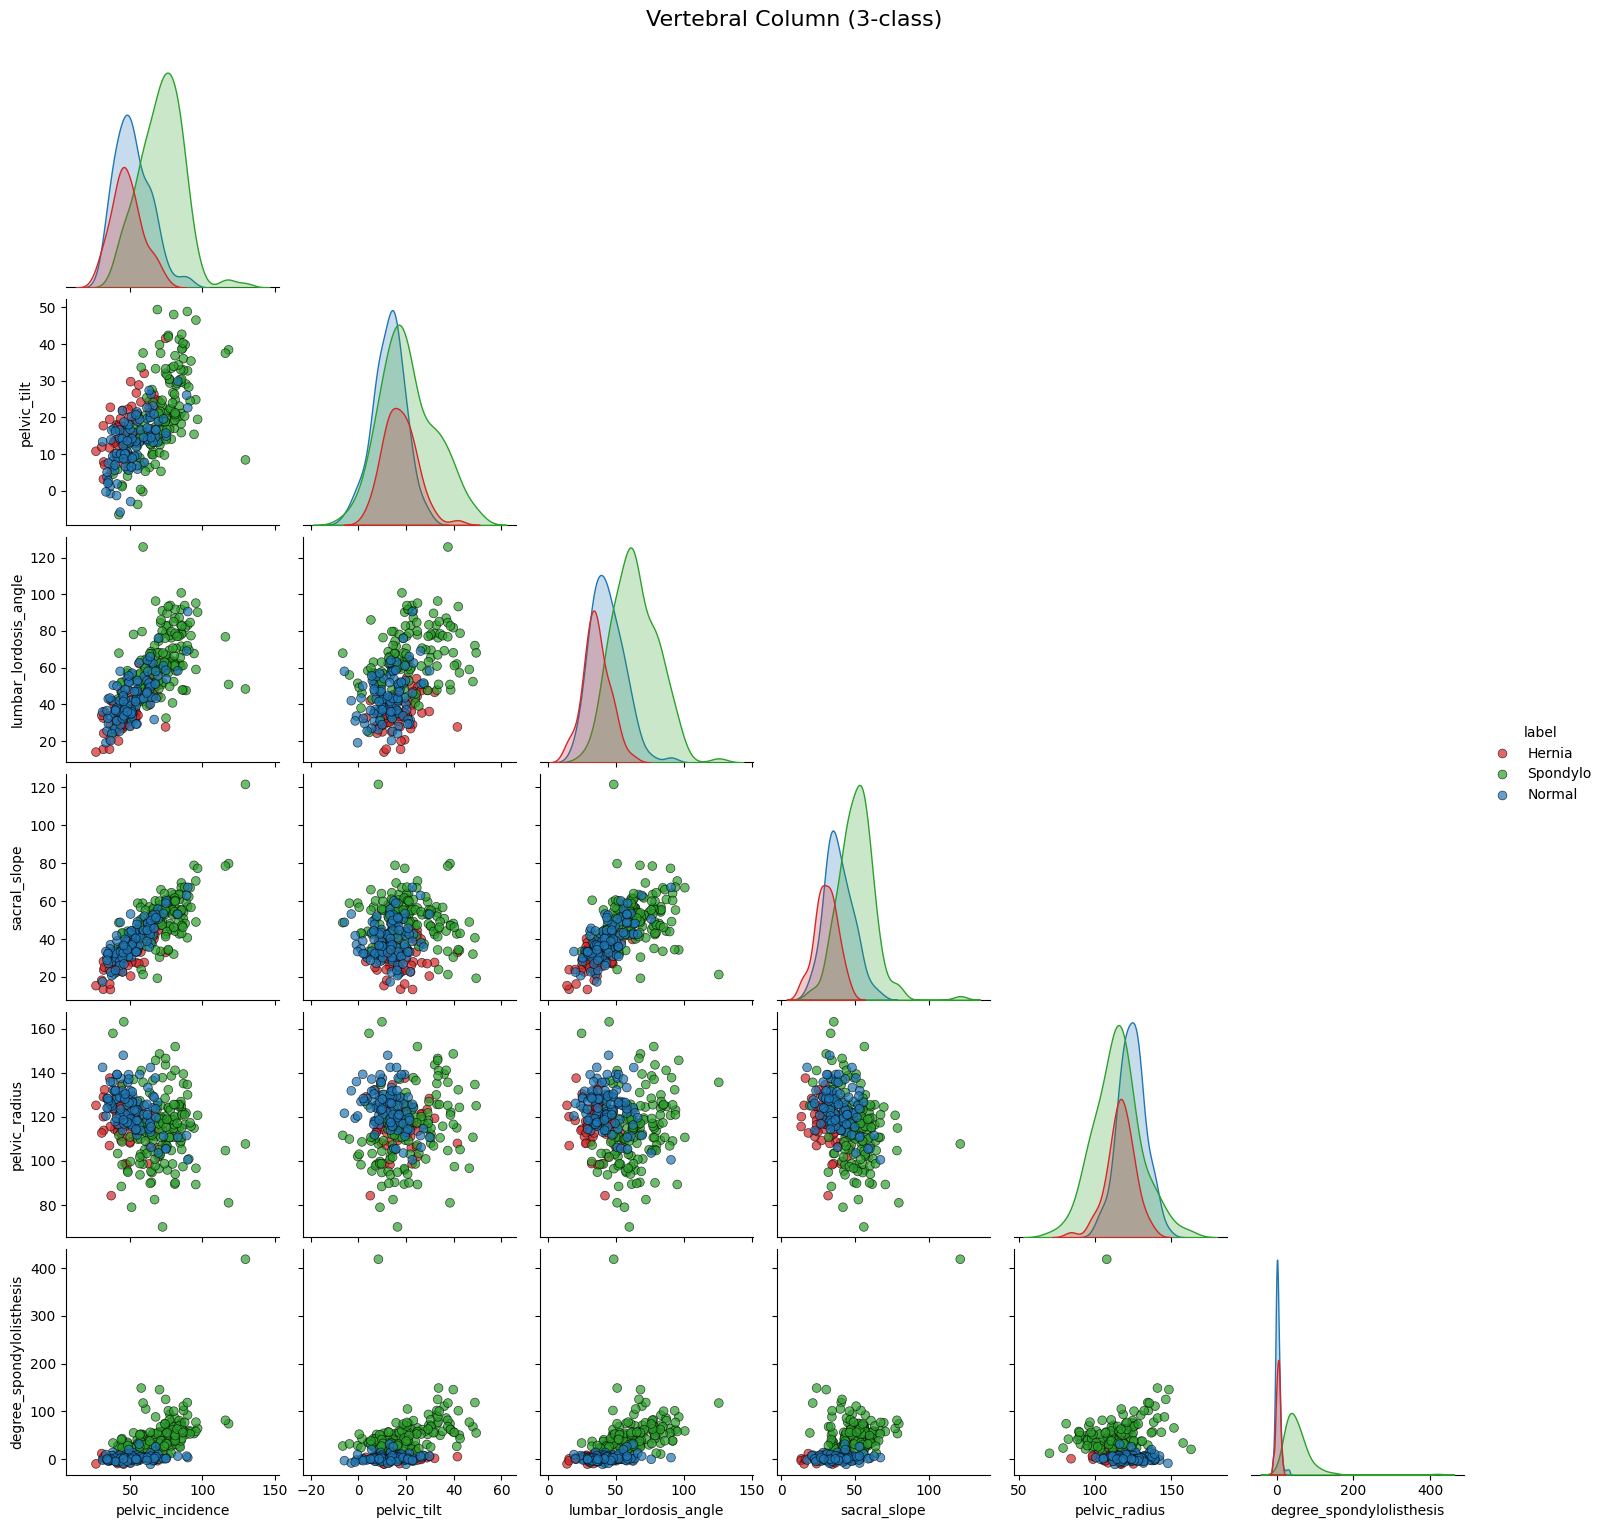

In [8]:
pairplot(df3, "Vertebral Column (3-class)", palette={"Normal": "#1f77b4", "Hernia": "#d62728", "Spondylo": "#2ca02c"})

### b - (ii). Boxplots of features data split by class

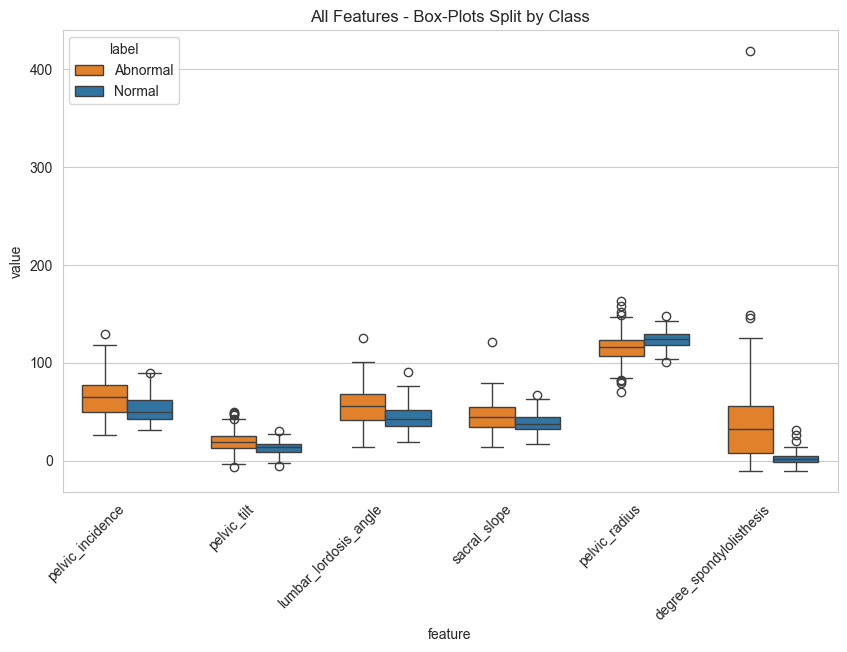

In [9]:
long = df2.melt(id_vars="label", var_name="feature", value_name="value")
sns.set_style("whitegrid")   
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=long,
    x="feature", y="value",
    hue="label",
    palette={"Normal": "#1f77b4", "Abnormal": "#ff7f0e"},
    width = 0.7
)
plt.xticks(rotation=45, ha="right")
plt.title("All Features - Box-Plots Split by Class")
plt.show()

### b - (iii). Data Splitting and Feature Extraction

adding a binary label to the dataframe

In [10]:
label_for_binary = {"Normal": 0, "Abnormal": 1}
df2["y"] = df2["label"].map(label_for_binary)

Seperating df into normal and abnormal and also splitting df into train and test data

In [11]:
normal = df2[df2.y == 0]
abnormal = df2[df2.y == 1]

normal_train = normal.iloc[:70]     
abnormal_train = abnormal.iloc[:140]   


train = pd.concat([normal_train, abnormal_train])
test = df2.drop(train.index).reset_index(drop=True)

Splitting into X (features) and y (labels) to visually see shape of testing and training data

In [12]:
feature_cols = df2.columns[:-2]       # everything except 'label' & 'y'

X_train, y_train = train[feature_cols], train["y"]
X_test,  y_test  = test[feature_cols],  test["y"]

print("Train shape :", X_train.shape, "— Class 0:", (y_train==0).sum(), "Class 1:", (y_train==1).sum())
print("Test  shape :", X_test.shape,  "— Class 0:", (y_test==0).sum(), "Class 1:", (y_test==1).sum())

Train shape : (210, 6) — Class 0: 70 Class 1: 140
Test  shape : (100, 6) — Class 0: 30 Class 1: 70


# Lets classify using KNN on Vertebral Column Data Set - c

### c - (i) and (ii). K-Nearest Neighbors Classification, Error Rate Visualization, Best K Selection, Confusion Matrix and Metrics

Running loops of K values and computing error rates in KNN

In [13]:
ks = list(range(208, 0, -3))       
train_err, test_err = [], []

for k in ks:
    knn = KNeighborsClassifier(
        n_neighbors=k,
        metric="euclidean",
        weights="uniform"                     
    )
    knn.fit(X_train, y_train)

    train_err.append(1 - knn.score(X_train, y_train))
    test_err.append(1 - knn.score(X_test,  y_test))
best_idx = np.argmin(test_err)
k_star   = ks[best_idx]
print(f"Lowest test error = {test_err[best_idx]:.3f} at k* = {k_star}")

Lowest test error = 0.060 at k* = 4


Plotting the graph to see the results visually (assisted by gpt)

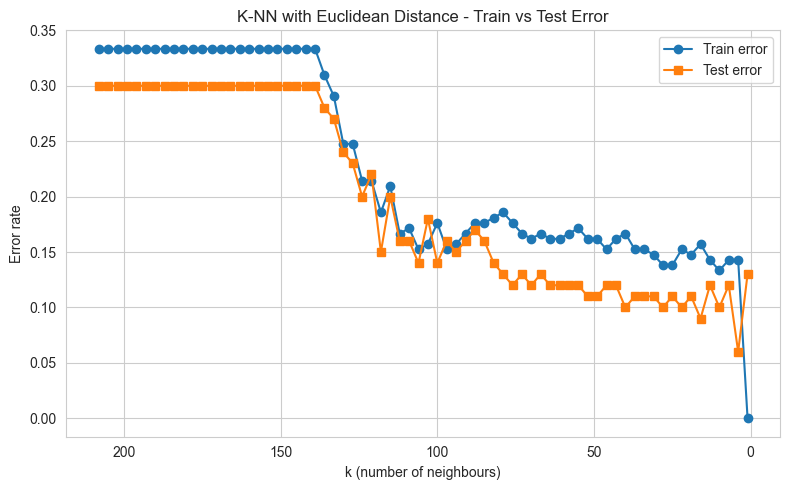

In [14]:
plt.figure(figsize=(8, 5))
plt.plot(ks, train_err, marker="o", label="Train error")
plt.plot(ks, test_err,  marker="s", label="Test error")
plt.gca().invert_xaxis()                      
plt.xlabel("k (number of neighbours)")
plt.ylabel("Error rate")
plt.title("K-NN with Euclidean Distance - Train vs Test Error")
plt.legend()
plt.tight_layout()
plt.show()

Training a fresh model with k* previously obtained for neighbors and creating predictions using test set

In [15]:
knn_best = KNeighborsClassifier(n_neighbors=k_star)
knn_best.fit(X_train, y_train)

y_pred = knn_best.predict(X_test)

Now we calculate the confusion matrix, true positive rate, true negative rate, precision, and F1-score (gpt assisted)

In [16]:
cm  = confusion_matrix(y_test, y_pred, labels=[0, 1])  
TN, FP, FN, TP = cm.ravel()

TPR = TP / (TP + FN)   
TNR = TN / (TN + FP)   
PREC = precision_score(y_test, y_pred, pos_label=1)
F1   = f1_score(y_test, y_pred, pos_label=1)

print(f"Most Suitable K: {k_star}")
print("\nConfusion matrix [[TN FP][FN TP]]\n", cm)
print(f"\nTrue-positive rate (recall):      {TPR:.3f}")
print(f"True-negative rate (specificity): {TNR:.3f}")
print(f"Precision:                        {PREC:.3f}")
print(f"F1-score:                         {F1:.3f}")


Most Suitable K: 4

Confusion matrix [[TN FP][FN TP]]
 [[25  5]
 [ 1 69]]

True-positive rate (recall):      0.986
True-negative rate (specificity): 0.833
Precision:                        0.932
F1-score:                         0.958


### c - (iii). Learning Curve and Subset Analysis for KNN

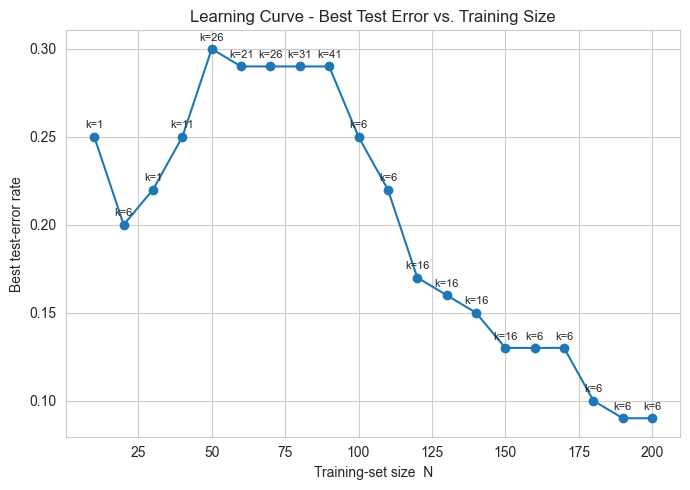

In [17]:
train_normal = train[train.y == 0]          
train_abnormal = train[train.y == 1]          

sizes, best_errors, best_ks = [], [], []

for N in range(10, 210, 10):                       
    n0 = N // 3                                    
    n1 = N - n0                                    
    sub_train = pd.concat([train_normal.iloc[:n0], train_abnormal.iloc[:n1]]).reset_index(drop=True)

    X_sub, y_sub = sub_train[feature_cols], sub_train["y"]
    X_test, y_test = test[feature_cols], test["y"]

    best_err, best_k = 1.0, None
    for k in range(1, N, 5):                       
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_sub, y_sub)
        err = 1 - knn.score(X_test, y_test)
        if err < best_err or (err == best_err and (best_k is None or k < best_k)):
            best_err, best_k = err, k

    sizes.append(N)
    best_errors.append(best_err)
    best_ks.append(best_k)

plt.figure(figsize=(7, 5))
plt.plot(sizes, best_errors, marker="o")
plt.xlabel("Training-set size  N")
plt.ylabel("Best test-error rate")
plt.title("Learning Curve - Best Test Error vs. Training Size")
plt.grid(True)

for N, err, k in zip(sizes, best_errors, best_ks):
    plt.annotate(f"k={k}", (N, err), textcoords="offset points", xytext=(0, 6), ha="center", fontsize=8)

plt.tight_layout()
plt.show()


# Further exploration some variants of KNN - D


Comparing distance metrics: Manhattan, Minkowski (vary p), Chebyshev, Mahalanobis

function to loop k = 1,6,11,…,196  and returning (best_k, best_err)

In [18]:
def best_k_error(train_features, train_labels, test_features, test_labels, metric, metric_params=None):
    best_err, best_k = 1.0, None
    for k in range(1, 196, 5):                         
        knn = KNeighborsClassifier(
            n_neighbors=k,
            metric=metric,
            metric_params=metric_params or {}
        )
        knn.fit(train_features, train_labels)
        err = 1 - accuracy_score(test_labels, knn.predict(test_features))
        if err < best_err or (err == best_err and (best_k is None or k < best_k)):
            best_err, best_k = err, k
    return best_k, best_err

In [19]:
results = []   # to collect rows for the summary table

### d - (i) - A. Manhattan  (Minkowski with p = 1)

In [20]:
k_manh, err_manh = best_k_error(X_train, y_train, X_test, y_test, metric="manhattan")
results.append(("Manhattan (p=1)", "-", k_manh, err_manh))
print(f"Manhattan Distance (p=1): Best k = {k_manh}, Test Error = {err_manh:.3f}")

Manhattan Distance (p=1): Best k = 6, Test Error = 0.110


### d - (i) - B. General Minkowski – same k*, vary log10(p) ∈ {0.1,…,1.0}

In [21]:
best_p_log10, best_err = None, 1.0
for log10p in np.arange(0.1, 1, 0.1):
    p = 10**log10p
    knn = KNeighborsClassifier(n_neighbors=k_manh, metric="minkowski", p=p)
    knn.fit(X_train, y_train)
    err = 1 - accuracy_score(y_test, knn.predict(X_test))
    if err < best_err:
        best_err, best_p_log10 = err, log10p

results.append((f"Minkowski (best log10 p = {best_p_log10:.1f})", f"k fixed = {k_manh}", k_manh, best_err))
print(f"Minkowski Distance (best log10 p = {best_p_log10:.1f}): Best k = {k_manh}, Test Error = {best_err:.3f}")

Minkowski Distance (best log10 p = 0.6): Best k = 6, Test Error = 0.060


### d - (i) - C. Chebyshev  (p → ∞)

In [22]:
k_cheb, err_cheb = best_k_error(X_train, y_train, X_test, y_test, metric="chebyshev")
results.append(("Chebyshev (p→∞)", "-", k_cheb, err_cheb))
print(f"Chebyshev Distance (p→∞): Best k = {k_cheb}, Test Error = {err_cheb:.3f}")

Chebyshev Distance (p→∞): Best k = 16, Test Error = 0.080


### d - (ii). Mahalanobis – on raw (unscaled) data so Σ ≠ I

In [23]:
V  = np.cov(X_train, rowvar=False)       
VI = pinv(V)                             
k_mah, err_mah = best_k_error(X_train, y_train, X_test, y_test, metric="mahalanobis", metric_params={"VI": VI})
results.append(("Mahalanobis", "-", k_mah, err_mah))
print(f"Mahalanobis Distance: Best k = {k_mah}, Test Error = {err_mah:.3f}")

Mahalanobis Distance: Best k = 1, Test Error = 0.170


### d. Summary table comparing the above tested metrics

In [24]:
summary = pd.DataFrame(results, columns=["Metric", "Details", "k*", "Test error"])
summary.set_index("Metric", inplace=True)
display(summary)

,Details,k*,Test error
Metric,,,
Manhattan (p=1),-,6,0.11
Minkowski (best log10 p = 0.6),k fixed = 6,6,0.06
Chebyshev (p→∞),-,16,0.08
Mahalanobis,-,1,0.17


# Distance-Weighted KNN Implementation - e

In [25]:
def best_k_weighted(train_X, train_y, test_X, test_y, distance_metric, metric_options=None):
    if metric_options is None:
        metric_options = {}
    best_err, best_k = 1.0, None
    for k in range(1, 197, 5):
        knn = KNeighborsClassifier(
            n_neighbors=k,
            metric=distance_metric,
            metric_params=metric_options,
            weights="distance"
        )
        knn.fit(train_X, train_y)
        err = 1 - accuracy_score(test_y, knn.predict(test_X))
        if err < best_err or (err == best_err and (best_k is None or k < best_k)):
            best_err, best_k = err, k
    return best_k, best_err

In [26]:
summary_rows = [] # to collect rows for the summary table

Euclidean  (Minkowski p = 2  — default)

In [27]:
k_euc, err_euc = best_k_weighted(X_train, y_train, X_test, y_test, distance_metric="euclidean")
summary_rows.append(("Euclidean",   k_euc, err_euc))

Manhattan  (Minkowski p = 1)

In [28]:
k_man, err_man = best_k_weighted(X_train, y_train, X_test, y_test, distance_metric="manhattan")
summary_rows.append(("Manhattan",   k_man, err_man))

Chebyshev  (Minkowski p → ∞)

In [29]:
k_cheb, err_cheb = best_k_weighted(X_train, y_train, X_test, y_test, distance_metric="chebyshev")
summary_rows.append(("Chebyshev",   k_cheb, err_cheb))

the results:

In [30]:
weighted_summary = pd.DataFrame(summary_rows, columns=["Metric", "Best k*", "Best test-error"])
weighted_summary.set_index("Metric", inplace=True)
display(weighted_summary)

,Best k*,Best test-error
Metric,,
Euclidean,6,0.10
Manhattan,26,0.10
Chebyshev,16,0.11


# Lowest test error - f

In [31]:
lowest_test_error = min(test_err)
k_at_min_error     = ks[test_err.index(lowest_test_error)]

print(f"Lowest test error = {lowest_test_error}  (achieved at k = {k_at_min_error})")

Lowest test error = 0.06000000000000005  (achieved at k = 4)
